# Ejercicio de Autoencoders

Para este ejercicio vamos a utilizar una base de datos de caras de personajes públicos descargada de [aquí](http://vis-www.cs.umass.edu/lfw/#download)

In [1]:
import pandas as pd
import tensorflow as tf
import tarfile
import tqdm
import cv2
import os

from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

In [2]:
ATTRS_NAME = "lfw_attributes.txt"
IMAGES_NAME = "lfw-deepfunneled.tar"
RAW_IMAGES_NAME = "lfw.tar"

In [3]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [4]:
# Descargamos las imágenes
!pip install --upgrade --no-cache-dir gdown
## Pare evitar un error de permiso

!gdown --id 1BuleEi4ZcRtbCYH0wN-3GiFBmRk6QOC1 # lfw-deepfunneled.tar
!gdown --id 1BvfcR7PY5yAC34-vVL0mxuskUrFgStUI # lfw.tar
!gdown --id 1BuC1cb5JzzpTdsy-iDFP3J5t1GWWkJ26 # lfw_attributes.txt


  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1BuleEi4ZcRtbCYH0wN-3GiFBmRk6QOC1
From (redirected): https://drive.google.com/uc?id=1BuleEi4ZcRtbCYH0wN-3GiFBmRk6QOC1&confirm=t&uuid=e73543f9-3ed2-47c4-8c04-f2e5dac5c7fa
To: /content/lfw-deepfunneled.tar
100% 127M/127M [00:02<00:00, 43.3MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1BvfcR7PY5yAC34-vVL0mxuskUrFgStUI
From (r

## Función para cargar el dataset de imágenes de caras

In [5]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [6]:
import numpy as np
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

<ipython-input-5-ca9b8ea3b148>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(f.getmembers()):


  0%|          | 0/18983 [00:00<?, ?it/s]

In [7]:
X = X.astype('float32') / 255.0 - 0.5

In [8]:
print(X.min(), X.max())

-0.5 0.5


In [9]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

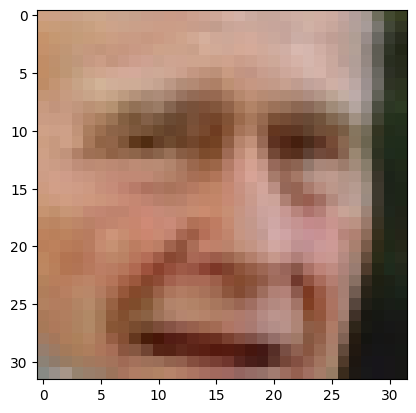

In [10]:
show_image(X[6])

**PREGUNTA**

1. Divide los datos X en X_train y X_test. 10% para test (random_state=42)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

**PREGUNTA**

2. Añade, en la función build_autoencoder(img_shape, latent_space_size), la parte del decodificador. La estructura del autoencoder es esta:

NOTA: np.prod(img_shape) es lo mismo que 32 x 32 x 3


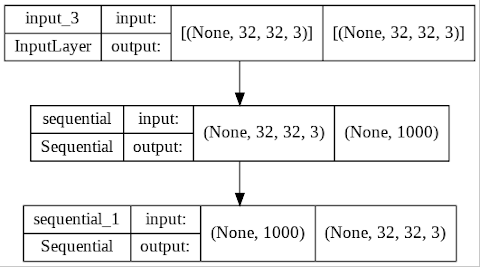

In [12]:
def build_autoencoder(img_shape, latent_space_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(latent_space_size))

    ''' Escribe el decodificador aquí '''
    # The decoder
    decoder = Sequential()
    decoder.add(Dense(img_shape[0] * img_shape[1] * img_shape[2], input_shape=(latent_space_size,)))
    decoder.add(Reshape(img_shape))


    return encoder, decoder

In [13]:
# IMG_SHAPE Será (32,32,3)
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)

inp = Input(IMG_SHAPE)
encoder = encoder(inp)
decoder = decoder(encoder)

autoencoder = Model(inp,decoder)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 1000)              3073000   
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         3075072   
                                                                 
Total params: 6148072 (23.45 MB)
Trainable params: 6148072 (23.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


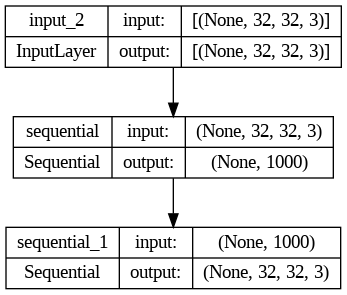

In [14]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

**PREGUNTA**
3. Entrena el modelo con 20 épocas y validation_split = 0.1

In [15]:
history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, validation_split=0.10)

Epoch 1/20
333/333 [==============================] - 5s 9ms/step - loss: 0.0090 - val_loss: 0.0047
Epoch 2/20
333/333 [==============================] - 3s 9ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 3/20
333/333 [==============================] - 4s 12ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/20
333/333 [==============================] - 3s 10ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/20
333/333 [==============================] - 3s 8ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/20
333/333 [==============================] - 3s 9ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/20
333/333 [==============================] - 3s 10ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/20
333/333 [==============================] - 4s 13ms/step - loss: 0.0010 - val_loss: 9.4436e-04
Epoch 9/20
333/333 [==============================] - 3s 10ms/step - loss: 8.7029e-04 - val_loss: 8.9113e-04
Epoch 10/20
333/333 [==============================] - 3s 10ms/step - loss: 7.7066e

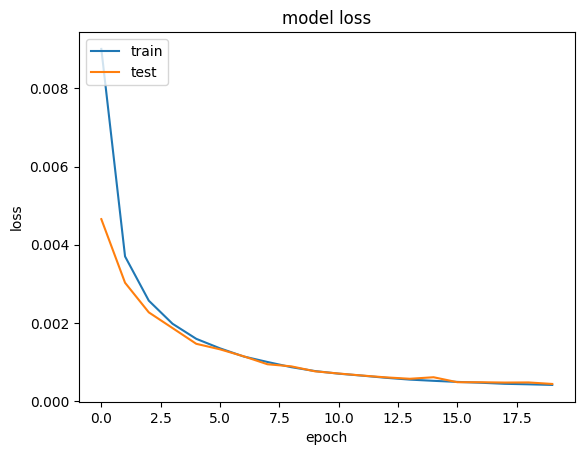

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
def visualize(img,autoencoder):
    """Dibuja las imágenes origianl y reconstruida """
    # img[None] tendrá la forma (1, 32, 32, 3) igual a la entrada del modelo
    reconst = autoencoder.predict(img[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reconst)
    plt.show()


**PREGUNTA**
4. Muestra las 5 primeras imágenes del X_test llamando a visuaize()

1/1 [==============================] - 0s 292ms/step


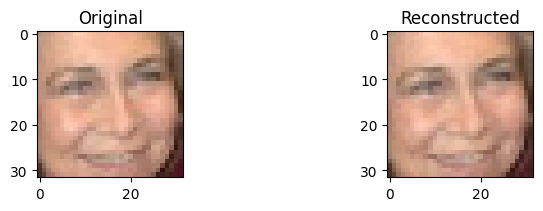

1/1 [==============================] - 0s 16ms/step


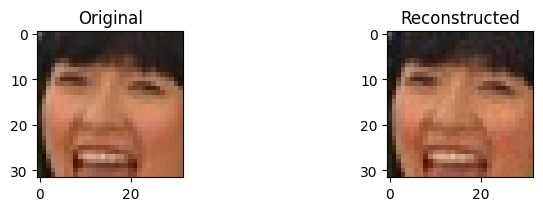

1/1 [==============================] - 0s 16ms/step


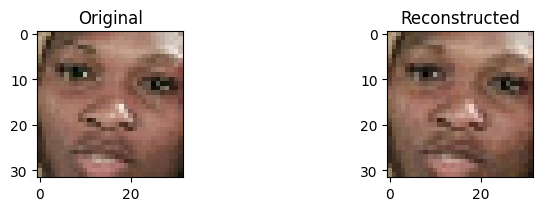

1/1 [==============================] - 0s 23ms/step


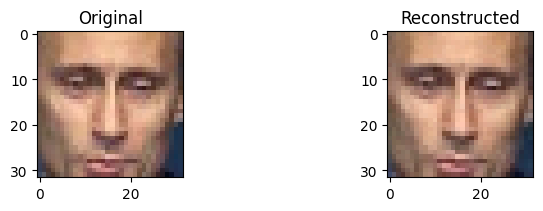

1/1 [==============================] - 0s 16ms/step


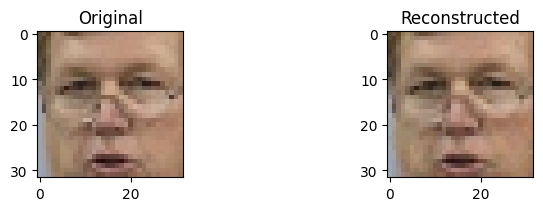

In [18]:
first_five_images = X_test[:5]

for img in first_five_images:
    visualize(img, autoencoder)


Creamos una función para añadir ruido aleatorio las imágenes:

In [19]:
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

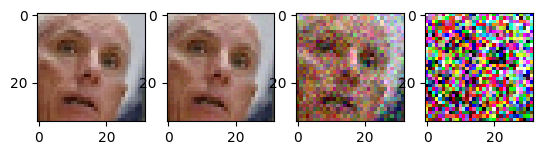

In [20]:
plt.subplot(1,4,1)
show_image(X_train[763])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[763:764],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[763:764],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[763:764],sigma=0.5)[0])

In [21]:
latent_space_size = 100

# Podemos utilizar un espacio latente mayor para tener mejor calidad
encoder, decoder = build_autoencoder(IMG_SHAPE, latent_space_size=latent_space_size)

inp = Input(IMG_SHAPE)
encoder = encoder(inp)
decoder = decoder(encoder)

autoencoder = Model(inp, decoder)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Época %i/25, Generando muestra con ruido..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # Entrenamos el modelo con los datos aumentados que incluyen ruido
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1, validation_split = 0.1)

Época 1/25, Generando muestra con ruido...
333/333 [==============================] - 2s 3ms/step - loss: 0.0135 - val_loss: 0.0089
Época 2/25, Generando muestra con ruido...
333/333 [==============================] - 2s 5ms/step - loss: 0.0076 - val_loss: 0.0065
Época 3/25, Generando muestra con ruido...
333/333 [==============================] - 1s 3ms/step - loss: 0.0059 - val_loss: 0.0053
Época 4/25, Generando muestra con ruido...
333/333 [==============================] - 1s 3ms/step - loss: 0.0050 - val_loss: 0.0047
Época 5/25, Generando muestra con ruido...
333/333 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0043
Época 6/25, Generando muestra con ruido...
333/333 [==============================] - 1s 4ms/step - loss: 0.0041 - val_loss: 0.0040
Época 7/25, Generando muestra con ruido...
333/333 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0039
Época 8/25, Generando muestra con ruido...
333/333 [========================

**PREGUNTA**
5. Aplica ruido gausiano a X_test y prueba a visualizar (llama a visualize()) la imagen con ruido y la reconstruida

1/1 [==============================] - 0s 71ms/step


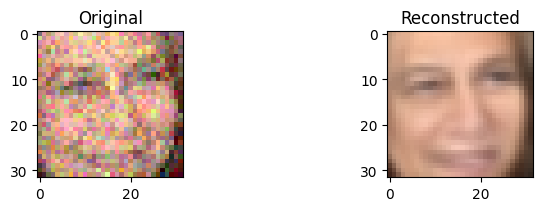

1/1 [==============================] - 0s 26ms/step


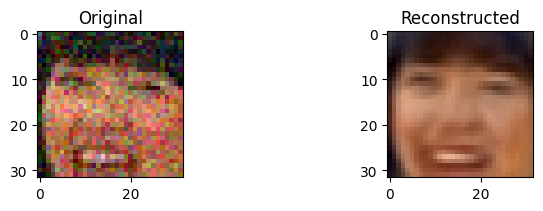

1/1 [==============================] - 0s 25ms/step


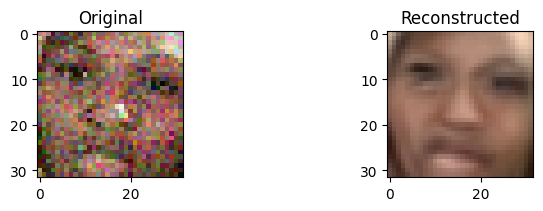

1/1 [==============================] - 0s 32ms/step


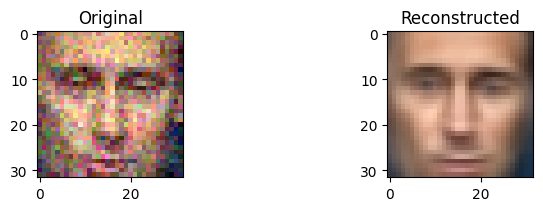

1/1 [==============================] - 0s 18ms/step


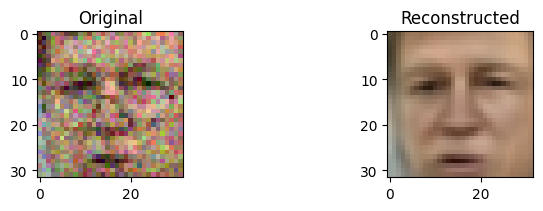

In [22]:
X_test_noise = apply_gaussian_noise(X_test)


for img in X_test_noise[:5]:
    visualize(img, autoencoder)


[Magic](https://drive.google.com/file/d/1G2XXHeskVX9_X9R2e0_kYXE17R1U78G7/view?usp=sharing)

**PREGUNTA**

6. Prueba a usar un espacio latente de tamaño 1000 para ver si mejora la calidad de las reconstrucciones

In [23]:
latent_space_size = 1000  # Aumentar el tamaño del espacio latente

# Construir el autoencoder con el nuevo tamaño del espacio latente
encoder, decoder = build_autoencoder(IMG_SHAPE, latent_space_size=latent_space_size)

# Combinar el encoder y decoder para formar el autoencoder completo
inp = Input(IMG_SHAPE)
encoder = encoder(inp)
decoder = decoder(encoder)

autoencoder = Model(inp, decoder)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Época %i/25, Generando muestra con ruido..." % (i + 1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # Entrenar el modelo con los datos aumentados que incluyen ruido
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1, validation_split=0.1)


Época 1/25, Generando muestra con ruido...
333/333 [==============================] - 2s 5ms/step - loss: 0.0147 - val_loss: 0.0087
Época 2/25, Generando muestra con ruido...
333/333 [==============================] - 1s 4ms/step - loss: 0.0070 - val_loss: 0.0056
Época 3/25, Generando muestra con ruido...
333/333 [==============================] - 2s 5ms/step - loss: 0.0048 - val_loss: 0.0043
Época 4/25, Generando muestra con ruido...
333/333 [==============================] - 2s 5ms/step - loss: 0.0038 - val_loss: 0.0035
Época 5/25, Generando muestra con ruido...
333/333 [==============================] - 2s 6ms/step - loss: 0.0032 - val_loss: 0.0031
Época 6/25, Generando muestra con ruido...
333/333 [==============================] - 1s 4ms/step - loss: 0.0029 - val_loss: 0.0028
Época 7/25, Generando muestra con ruido...
333/333 [==============================] - 1s 4ms/step - loss: 0.0027 - val_loss: 0.0027
Época 8/25, Generando muestra con ruido...
333/333 [========================

1/1 [==============================] - 0s 67ms/step


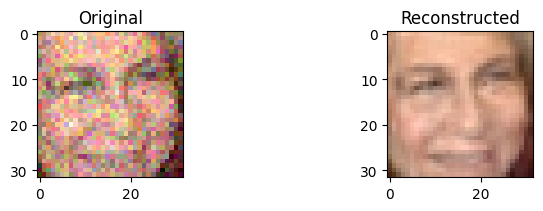

1/1 [==============================] - 0s 17ms/step


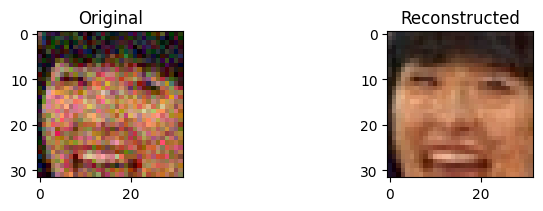

1/1 [==============================] - 0s 17ms/step


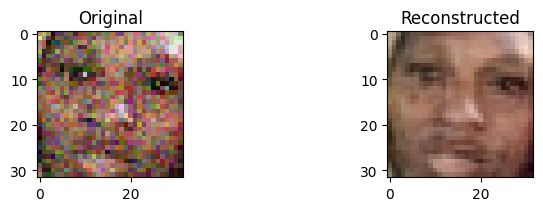

1/1 [==============================] - 0s 22ms/step


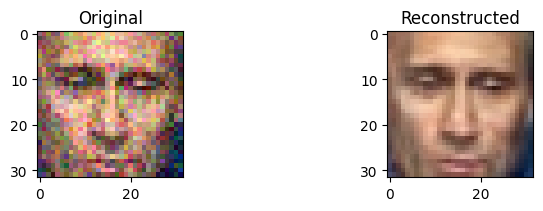

1/1 [==============================] - 0s 18ms/step


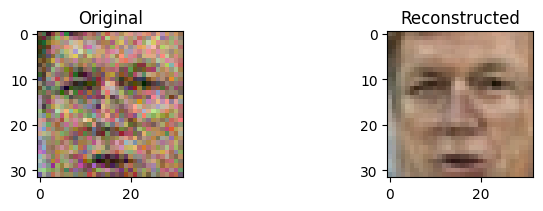

In [24]:
X_test_noise = apply_gaussian_noise(X_test)

for img in X_test_noise[:5]:
    visualize(img, autoencoder)


# Ejercicio de red GAN

In [25]:
import keras
import tensorflow as tf
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D, Flatten, Dropout
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam

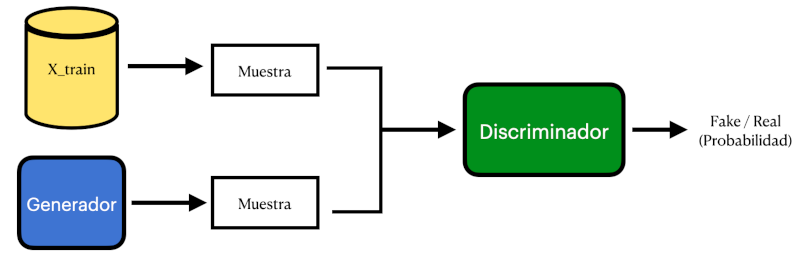

Vamos a crear una GAN a partir de las imágenes de [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) (50.000 imágenes pertenecientes a 10 categorías). Nosotros usaremos sólo la clase de los aviones, para generar imágenes sintéticas.

## Red generadora de imágenes

Lo primero que tenemos que saber es la forma que han de tener las imágenes generadas para que tengan las mismas dimensiones que las imágenes reales de entrenamiento. En nuestro caso, son imágenes de 32 x 32 x 3.

Al principio, el generador creará ruido aleatorio, para ir convolucionando hacia imágenes cada vez más similares a la realidad.

**PREGUNTA**

7. Crea la función crear_generador() que devuelve el modelo generador de una GAN.

>En este modelo usaremos:
* Capa Densa: es la capa de ruido de nuestro generador.
* Conv2DTranspose: esto permite convolucionar hacia atrás, es decir, aumentar y convolucionar la imagen al mismo tiempo. Es el equivalente a utilizar la función UpSampling2D seguida de Conv2D.
* LeakyReLU: es mejor que las funciones de ReLU, porque evita el desvanecimiento de gradiente. Utiliza el parámetro **alpha=0.2**
* BatchNormalization: Puede obtener mejores resultados. En este caso no lo hemos usado porque después de probarlo no mejoraba los resultados.
Este modelo nos permite transformar un vector unidimensional en una matriz tridimensional.

>Además hay que tener en cuenta que la forma de la salida de la red generativa tiene que ser igual a la forma de las imágenes reales. Para lograrlo utilizaremos la función Conv2DTranspose y stride 2, que duplica el tamañano en cada convolución.

>**Para la última capa Conv2D utiliza la función de activación 'tanh'**

>La estructura será la siguiente:

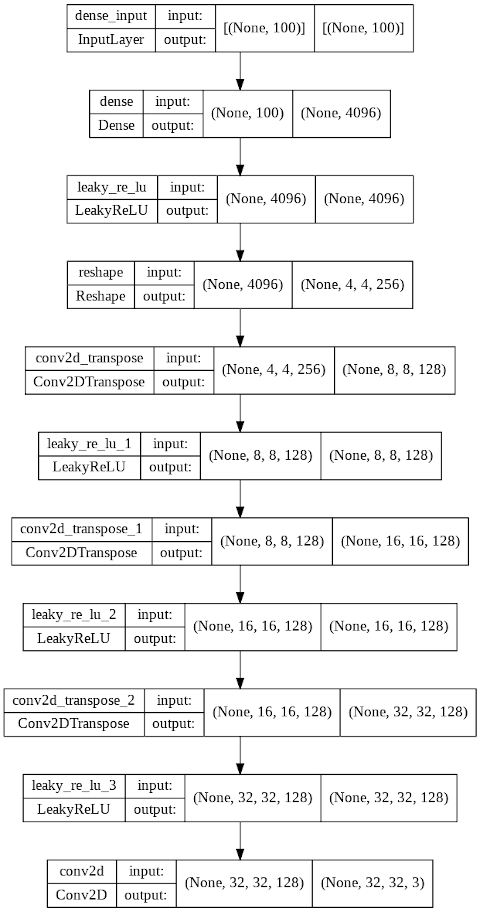

In [26]:

def crear_generador(latent_dim):
    modelo = tf.keras.Sequential()
    modelo.add(Dense(4096, input_dim=(latent_dim)))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(Reshape((4, 4, 256)))
    modelo.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    modelo.add(LeakyReLU(alpha=0.2))
    modelo.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return modelo

modelo_generador = crear_generador(100)

modelo_generador.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         295040    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       147584    
 Transpose)                                           

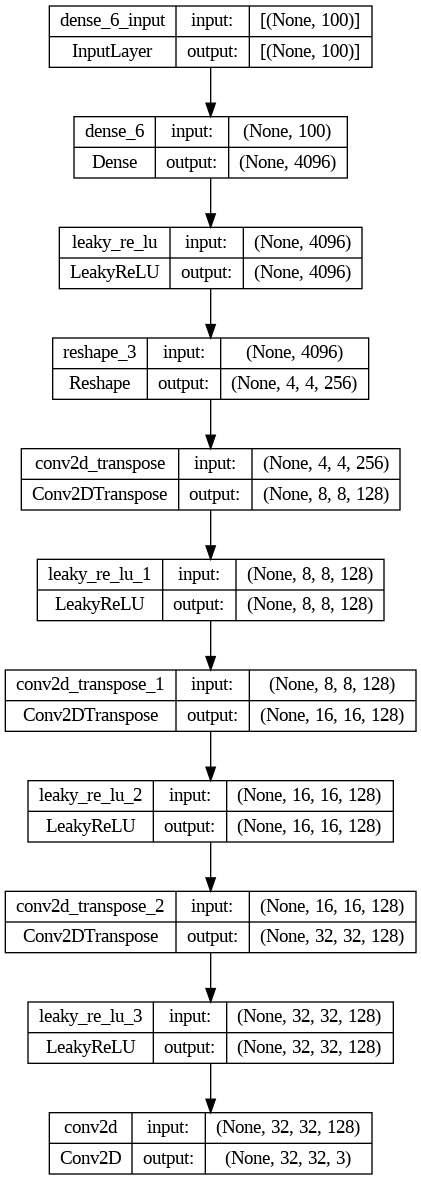

In [27]:
tf.keras.utils.plot_model(modelo_generador, show_shapes=True)

In [62]:
latent_dim = 100
n_samples = 40
# Definir datos de entrada
def generar_espacio_latente(latent_dim, n_samples):
	# Generamos puntos en el espacio latente
	x_input = np.random.randn(latent_dim * n_samples)
	# Redimensionamos a un "lote" de entradas para la red
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def crear_datos_fake(modelo_generador, n_muestras):
  input = generar_espacio_latente(latent_dim, n_muestras)
  X = modelo_generador.predict(input)
  y = np.zeros((n_muestras, 1))
  return X,y

In [63]:
def generar_observaciones_reales(dataset, n_samples):
	# Elegimos registros aleatorios
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	# Generamos clase "real" con la etiqueta "1"
	y = np.ones((n_samples, 1))
	return X, y

Nuestro modelo debería generar ruido aleatorio de 32 x 32

Comprobamos si funciona:

**PREGUNTA**

8. Muestra 4 datos Fake generados

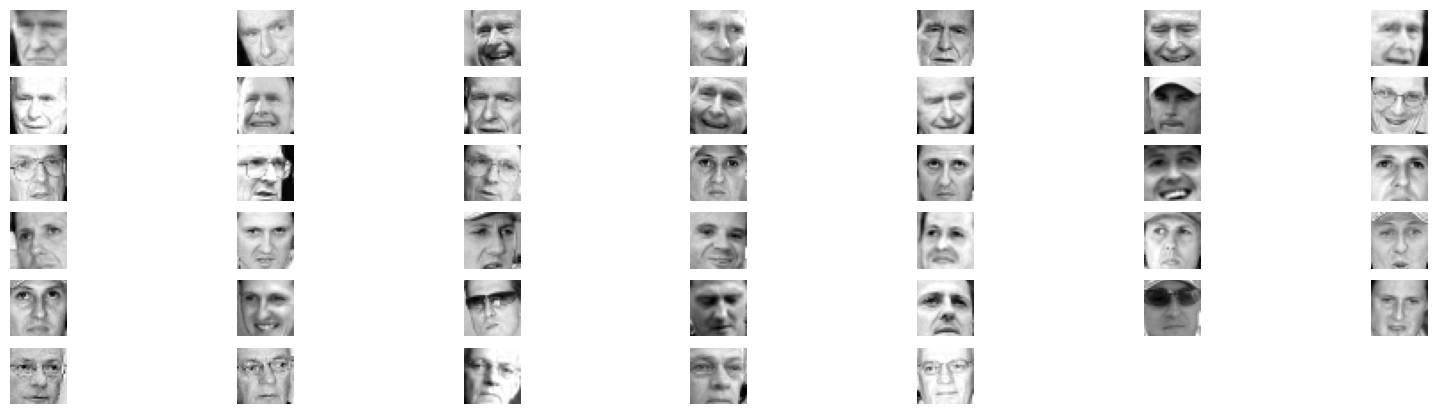

In [64]:
# Escalamos los valores de los píxeles de [-1,1] a [0,1] para una correcta visualización
X = (X + 1) / 2.0
plt.figure(figsize=(20, 6))
for i in range(n_samples):
	plt.subplot(7, 7, 1 + i)
	plt.axis('off')
	plt.imshow(X[i, :, :, 0], cmap='gray')
plt.show()


**PREGUNTA**

9. Crea una función crear_discriminador() que devolverá un modelo discriminador de imágenes con la estructura siguiente:

NOTA: Usa alpha=0.2 para LearyRelu y kernel_size=3 para las convolucionales. Dropout de 0.4


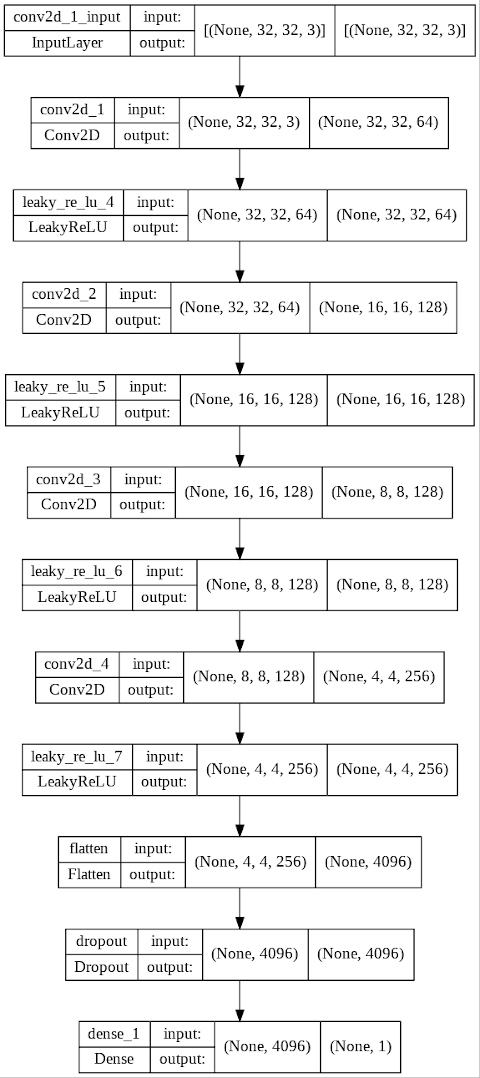

In [65]:
from tensorflow.keras import layers, models

def crear_discriminador():
    modelo = models.Sequential()
    modelo.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', input_shape=[32, 32, 3]))
    modelo.add(layers.LeakyReLU(alpha=0.2))
    modelo.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    modelo.add(layers.LeakyReLU(alpha=0.2))
    modelo.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    modelo.add(layers.LeakyReLU(alpha=0.2))
    modelo.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    modelo.add(layers.LeakyReLU(alpha=0.2))
    modelo.add(layers.Flatten())
    modelo.add(layers.Dropout(0.3))
    modelo.add(layers.Dense(1, activation='sigmoid'))

    return modelo


In [66]:
discriminador = crear_discriminador()
opt = Adam(lr=0.0002, beta_1=0.5)
discriminador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])
discriminador.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 256)       

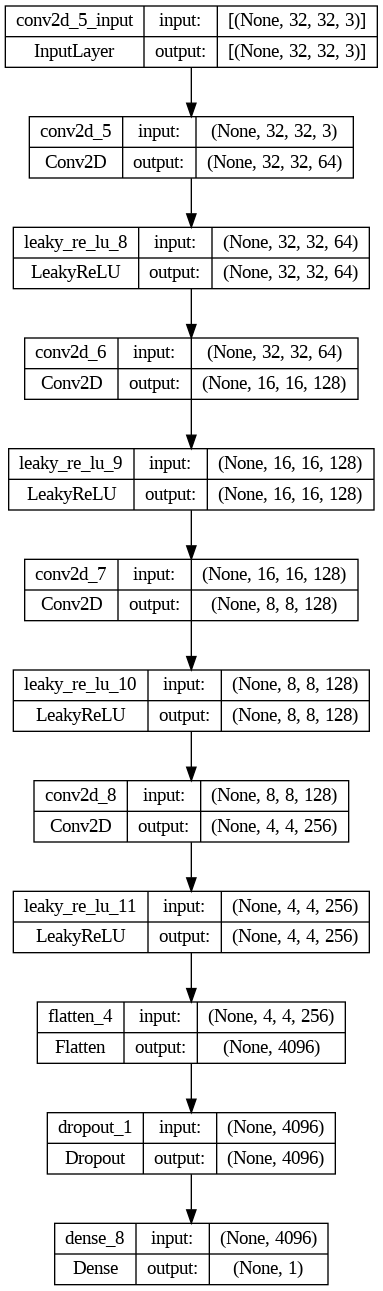

In [67]:
tf.keras.utils.plot_model(discriminador, show_shapes=True)

Cargamos imágenes de CIFAR10 y nos quedanos sólo con las de los aviones:

In [68]:
from keras.datasets import cifar10

def cargar_imagenes():
    (Xtrain, Ytrain), (_, _) = cifar10.load_data()

    # Nos quedamos con los aviones
    indice = np.where(Ytrain == 0)
    indice = indice[0] # en indice[1] están las etiquetas
    Xtrain = Xtrain[indice, :,:,:]

    # Normalizamos los datos
    X = Xtrain.astype('float32')
    X = (X - 127.5) / 127.5

    return X

print(cargar_imagenes().shape)

(5000, 32, 32, 3)


In [69]:
import random

def cargar_datos_reales(dataset, n_muestras):
  ix = np.random.randint(0, dataset.shape[0], n_muestras)
  X = dataset[ix]
  y = np.ones((n_muestras, 1))
  return X,y

def cargar_datos_fake(n_muestras):
  X = np.random.rand(32 * 32 * 3 * n_muestras)
  X = -1 + X * 2
  X = X.reshape((n_muestras, 32,32,3))
  y = np.zeros((n_muestras, 1))
  return X,y

In [70]:
# Nota: funciona también sin entrenar primero el discriminador
def entrenar_discriminador(modelo, dataset, n_iteraciones=20, batch = 128):
  medio_batch = int(batch/2)

  for i in range(n_iteraciones):
    X_real, y_real = cargar_datos_reales(dataset, medio_batch)
    _, acc_real = modelo.train_on_batch(X_real, y_real)

    X_fake, y_fake = cargar_datos_fake(medio_batch)
    _, acc_fake = modelo.train_on_batch(X_fake, y_fake)

    print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))

**PREGUNTA**

10. Entrena el discriminador llamando a entrenar_discriminador()

>(dos líneas de código)

In [71]:
dataset = cargar_imagenes()
entrenar_discriminador(discriminador, dataset)


1 Real:96.875, Fake:0.0
2 Real:100.0, Fake:0.0
3 Real:93.75, Fake:23.4375
4 Real:92.1875, Fake:90.625
5 Real:92.1875, Fake:100.0
6 Real:96.875, Fake:100.0
7 Real:98.4375, Fake:100.0
8 Real:96.875, Fake:100.0
9 Real:100.0, Fake:100.0
10 Real:100.0, Fake:100.0
11 Real:100.0, Fake:100.0
12 Real:100.0, Fake:100.0
13 Real:100.0, Fake:100.0
14 Real:100.0, Fake:100.0
15 Real:96.875, Fake:100.0
16 Real:100.0, Fake:100.0
17 Real:100.0, Fake:100.0
18 Real:100.0, Fake:100.0
19 Real:100.0, Fake:100.0
20 Real:100.0, Fake:100.0


In [72]:
def crear_gan(discriminador, generador):
    discriminador.trainable=False
    # IMPORTANTE:
    # El discriminador por sí sólo sí será entrenable porque ya fue compilado en modelo_discriminador
    # , pero no será entrenamble en el modelo combinado GAN
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminador)

    opt = Adam(lr=0.0002,beta_1=0.5)
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

In [73]:
gan = crear_gan(discriminador, modelo_generador)
gan.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 32, 32, 3)         1007363   
                                                                 
 sequential_10 (Sequential)  (None, 1)                 522497    
                                                                 
Total params: 1529860 (5.84 MB)
Trainable params: 1007363 (3.84 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [75]:
def mostrar_imagenes_generadas(datos_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  # Hacemos que los datos vayan de 0 a 1
  datos_fake = (datos_fake + 1) / 2.0

  for i in range(10):
    plt.imshow(datos_fake[i])
    plt.axis('off')
    nombre = str(epoch) + '_imagen_generada_' + str(i) + '.png'
    plt.savefig(nombre, bbox_inches='tight')
    plt.close()

In [76]:
def evaluar_y_guardar(modelo_generador, epoch, medio_dataset):

  # We save the model
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  nombre = str(epoch) + '_' + str(now)+"_modelo_generador_" + '.h5'
  modelo_generador.save(nombre)

  # We generate new data
  X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)
  X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

  # We evaluate the model
  _, acc_real = discriminador.evaluate(X_real, Y_real)
  _, acc_fake = discriminador.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [77]:
def entrenamiento(modelo_generador, modelo_discriminador, gan, datos, epochs, n_batch, inicio = 0):
  dimension_batch = int(datos.shape[0]/n_batch)
  medio_dataset = int(n_batch/2)

  # Iteremos sobre las éopcas
  for epoch in range(inicio, inicio + epochs):
    # Iteramos sobre todos los batches
    for batch in range(n_batch):

      # Cargamos todos los datos
      X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)


      # Entrenamos discriminador con datos reales
      coste_discriminador_real, _ = modelo_discriminador.train_on_batch(X_real, Y_real)

      X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)
      # Entrenamos discriminador con datos fake
      coste_discriminador_fake, _ = modelo_discriminador.train_on_batch(X_fake, Y_fake)

      # Generamos datos de entrada para la GAN
      X_gan = generar_espacio_latente(latent_dim=100, n_samples=medio_dataset)
      Y_gan = np.ones((medio_dataset, 1))

      # Entrenamos la GAN con datos fake
      coste_gan = gan.train_on_batch(X_gan, Y_gan)

    # Cada 10 épocas mostramos los resultados y coste
    if (epoch+1) % 10 == 0:
      evaluar_y_guardar(modelo_generador,epoch = epoch, medio_dataset= medio_dataset)
      mostrar_imagenes_generadas(X_fake, epoch = epoch)

In [78]:
# Esto tarda unos 40 minutos en colab //
entrenamiento(modelo_generador, discriminador, gan, dataset, epochs = 100, n_batch=128, inicio = 0)

2/2 [==============================] - 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 7ms/step - loss: 0.2963 - accuracy: 0.8906
Acc Real:60.9375% Acc Fake:89.0625%
2/2 [==============================] - 0s 4ms/step


KeyboardInterrupt: 

In [ ]:
modelo_generador.save('modelo_generador.h5')

Mostramos unas cuantas imágenes de aviones del dataset. Las compararemos con las generadas por la GAN:

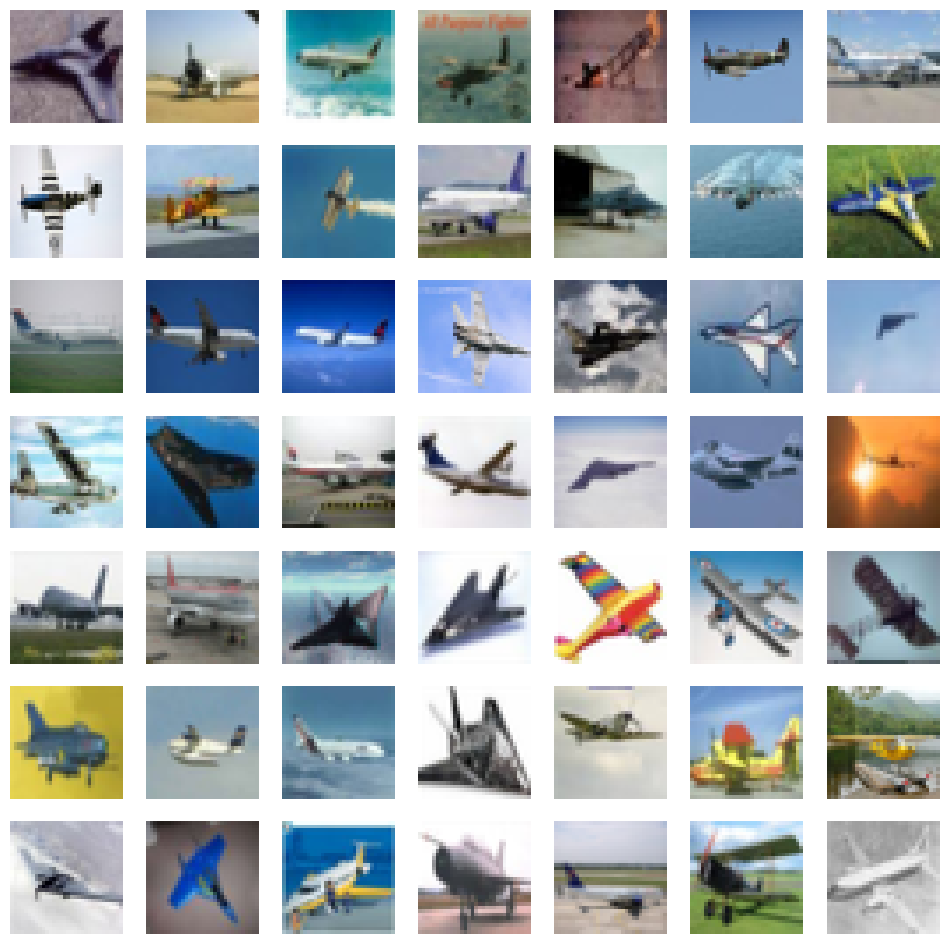

In [79]:
X_real, _ = cargar_datos_reales(dataset, 49)
X_real = (X_real+1)/2
plt.figure(figsize=(12,12))
for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X_real[i])

**PREGUNTA**

11. Muestra 49 imágenes generadas por la GAN

2/2 [==============================] - 0s 301ms/step


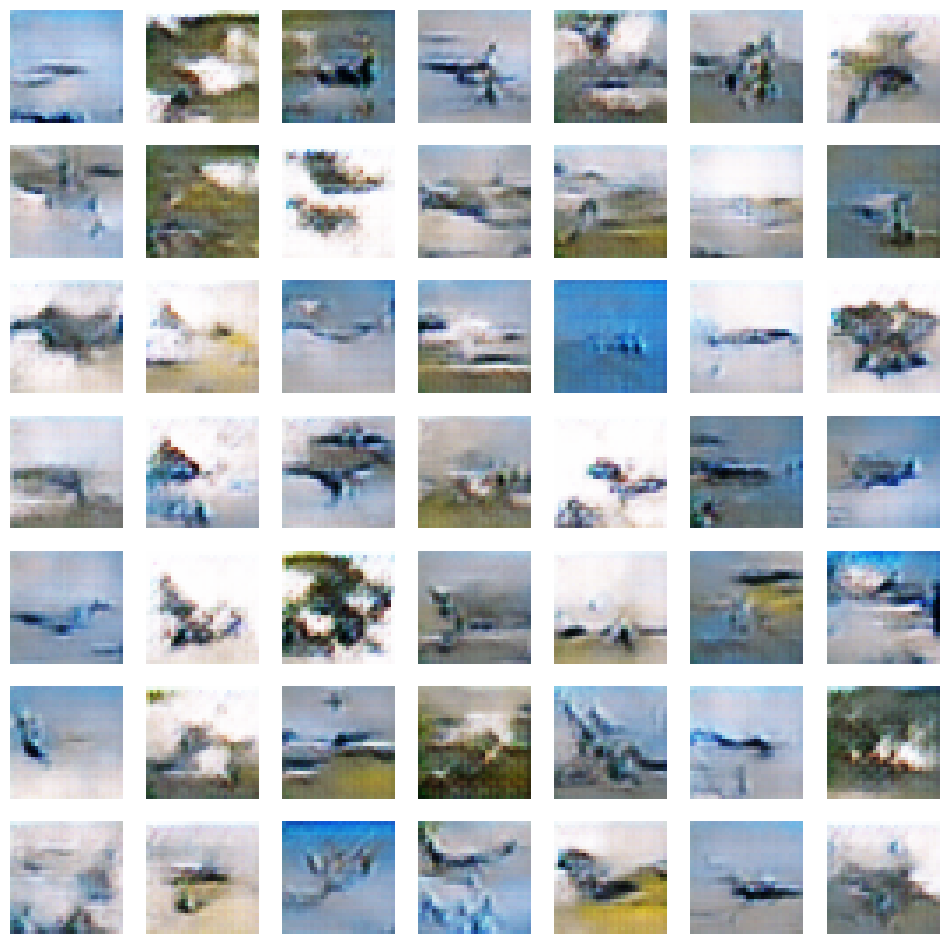

In [80]:
n_muestras = 49
datos_fake, _ = crear_datos_fake(modelo_generador, n_muestras)
datos_fake_visualizar = (datos_fake + 1) / 2.0

plt.figure(figsize=(12, 12))
for i in range(n_muestras):
    plt.subplot(7, 7, i + 1)
    plt.axis('off')
    plt.imshow(datos_fake_visualizar[i])
plt.show()


[Magic](https://drive.google.com/file/d/1G2XXHeskVX9_X9R2e0_kYXE17R1U78G7/view?usp=sharing)